In [101]:
from sealrtc import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy import signal
import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ol_values = np.load(joindata("openloop", "ol_f_1_z_stamp_03_11_2021_13_58_53.npy"))
dmc2wf = np.load(joindata("bestflats", "lodmc2wfe.npy"))
ol_values *= dmc2wf
fs = 100
nsteps = 10000
ident = SystemIdentifier(ol_values, fs=fs, N_vib_max=1)
klqg = ident.make_klqg_from_openloop()

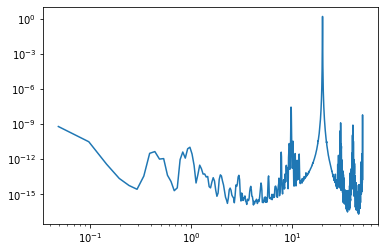

In [37]:
t, y = multivib(t=100, ws=2*np.pi*np.array([20]), ks=[0], sigmas=[0], dt=0.01)
f, p = genpsd(y, dt=0.01)
plt.loglog(f, p)

In [38]:
find_psd_peaks(f, p)

array([20.01953125])

In [218]:
def model_psd(freqs, f, k, sigma):
    phase = 2 * np.pi * freqs / fs
    a1, a2 = vib_coeffs(f, k)
    denom = np.abs(1 - a1 * np.exp(-1j * phase) - a2 * np.exp(-2j * phase))
    return np.log10(sigma ** 2 / fs / denom ** 2)


In [120]:
fcen = 20
kcen = 1e-4
s = 0.01
a1, a2 = vib_coeffs(fcen, kcen, fs=fs)
nsteps = 10000
x = np.zeros(nsteps,)
x[0], x[1] = np.random.normal(0, s, (2,))
for i in tqdm.trange(2, nsteps):
    x[i] = a1 * x[i-1] + a2 * x[i-2] + np.random.normal(0, s)
f, p = genpsd(x, dt=1/fs)

100%|██████████| 9998/9998 [00:00<00:00, 83028.06it/s]


In [147]:
"""def obj(X, fcen, freqs=f):
    k, sigma = X
    #return (model_psd(freqs, fcen, k, sigma) - p)
    f = 10 * np.log10(model_psd(freqs, fcen, k, sigma)) - 10 * np.log10(p)
    return f

def jac(X, fcen, freqs=f, fs=fs):
    k, sigma = X
    w = 2 * np.pi * freqs
    N = len(w)
    a1, a2 = vib_coeffs(fcen, k)
    Z = a1 ** 2 + a2 ** 2 + 2 * a1 * a2 * np.cos(w) - 2 * a1 * np.cos(w) - 2 * a2 * np.cos(2 * w)
    df_da1 = (10 / np.log(10)) * (1/Z) * (2*a1 + 2*a2 * np.cos(w) - 2*np.cos(w))
    df_da2 = (10 / np.log(10)) * (1/Z) * (2*a2 + 2*a1 * np.cos(w) - 2*np.cos(2*w))
    arg = 2 * np.pi * (fcen / fs) * np.sqrt(1 - k ** 2)
    da1_dk = -4 * np.pi * (fcen / fs) * np.cos(arg)
    da1_dk -= 4 * np.pi * (fcen / fs) * k * np.sqrt(1 - k ** 2) * np.sin(arg)
    da1_dk *= np.exp(-2 * k * np.pi * fcen / fs)
    da2_dk = 4 * np.pi * (fcen / fs) * np.exp(-4 * k * np.pi * fcen / fs)
    df_dk = df_da1 * da1_dk + df_da2 * da2_dk
    df_dsigma = -((10 / np.log(10)) / sigma) * np.ones(N)
    return np.column_stack((df_dk, df_dsigma)) 
    """

In [223]:
from lmfit import Model, Parameters
df = np.max(np.diff(f))
fit_params = Parameters()
fit_params.add('f', value=fcen, min=fcen-df, max=fcen+df)
fit_params.add('k', value=1e-4, min=1e-10, max=1)
fit_params.add('sigma', value=1e-1, min=1e-10, max=100)

In [224]:
psd_model = Model(model_psd)
res = psd_model.fit(np.log10(p), fit_params, freqs=f)
print(res.fit_report())

[[Model]]
    Model(model_psd)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 1024
    # variables        = 3
    chi-square         = 39.5536505
    reduced chi-square = 0.03874011
    Akaike info crit   = -3325.90535
    Bayesian info crit = -3311.11093
[[Variables]]
    f:      20.0077121 +/- 0.00499823 (0.02%) (init = 20)
    k:      1.1446e-07 +/- 83.8667256 (73274164970.30%) (init = 0.0001)
    sigma:  0.01356409 +/- 0.02704235 (199.37%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, sigma) = 1.000
    C(f, k)     = 0.874
    C(f, sigma) = 0.874


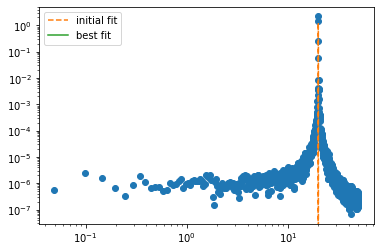

In [225]:
plt.loglog(f, p, 'o')
plt.loglog(f, res.init_fit, '--', label='initial fit')
plt.loglog(f, res.best_fit, '-', label='best fit')
plt.legend()
plt.show()

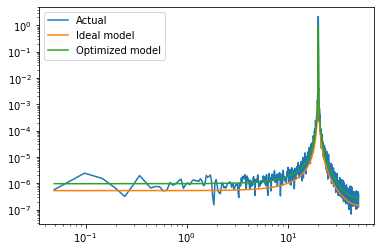

In [232]:
plt.loglog(f, p, label="Actual")
ph = 2 * np.pi * f / fs
denom = np.abs(1 - a1 * np.exp(-1j * ph) - a2 * np.exp(-2j * ph))
plt.loglog(f, s ** 2 / fs / denom ** 2, label=f"Ideal model")
plt.loglog(f, 10 ** res.best_fit, label=f"Optimized model")
plt.legend()

In [228]:
psd_model.eval(freqs=f, f=fcen, k=kcen, sigma=s)

array([-6.28087966, -6.28086191, -6.28083233, ..., -6.83582893,
       -6.8358383 , -6.83584142])

In [226]:
help(psd_model.eval)

Help on method eval in module lmfit.model:

eval(params=None, **kwargs) method of lmfit.model.Model instance
    Evaluate the model with supplied parameters and keyword arguments.
    
    Parameters
    -----------
    params : Parameters, optional
        Parameters to use in Model.
    **kwargs : optional
        Additional keyword arguments to pass to model function.
    
    Returns
    -------
    numpy.ndarray, float, int or complex
        Value of model given the parameters and other arguments.
    
    Notes
    -----
    1. if `params` is None, the values for all parameters are expected
    to be provided as keyword arguments. If `params` is given, and a
    keyword argument for a parameter value is also given, the keyword
    argument will be used.
    
    2. all non-parameter arguments for the model function, **including
    all the independent variables** will need to be passed in using
    keyword arguments.
    
    3. The return type depends on the model function. For